In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import cv2;

/cluster/home/henrfj/ProjectTDT17/yolo_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Inference

There are many ways to run inference using the detect.py file.

The source flag defines the source of our detector, which can be:

- A single image
- A folder of images
- Video
- Webcam

The **weights** flag defines the path of the model which we want to run our detector with.

**conf flag** is the thresholding objectness confidence.

**name** flag defines where the detections are stored. 
- We set this flag to yolo_road_det; therefore, the detections would be stored in runs/detect/yolo_road_det/.

>!python detect.py --source ../data/test/images --weights runs/train/.../weights/best.pt --conf 0.25 --name yolo_road_det

>model = torch.hub.load('ultralytics/yolov5', 'custom', path_or_model='your.pt')

Example:
>python yolov5/detect.py --source data/test/images --img 640 --weights yolov5s.pt --conf 0.25 --name test_detection --save-txt
- The "--save-txt" replaces the normal behaviour of drawing bboxes onto images as detection, with only returning txt labels.


**data will return on the format:** 9 0.33036 0.0244978 0.0332144 0.0460559
- this yolo format is for:
        > class x_center y_center widht height, in normalized coordinates!
- we want to submit on format: 
        > class x_min    y_min    x_max y_max,  in actual pixel coordinates!


In [2]:
### Need function to transform into the format we want.

# 1. Start new submission txt file
# 2. Iterate over all label files.
#       i.  get the name of the .txt label file
#       ii. get the width / height of the corresponding image.
#      iii. For each label (there can be more), add the (up to 5) datapoints to the txt. file: name.jpg class x_min y_min x_max y_max 
# 3. Save file!

In [3]:
path = 'yolov5/runs/detect/gpu_single_30/' # Path to currentdetection
# 'yolov5/runs/detect/gpu_single_30/'
# 'yolov5/runs/detect/gpu_2_15/'

#with open('submissions/test_submission.txt', 'w') as f:
    #f.write('readme') Writing an input, no newline
    
#    with open("...", "r") as g:
#        lines = g.readlines()
    
    
    

In [18]:
# get paths to all test labels
path = 'yolov5/runs/detect/gpu_single_30/'

test_label_paths = [os.path.join(path+'/labels', x) for x in os.listdir(path+'/labels')]
# Names of all files, on the format 'Norway_010095.txt'
file_names_txt = [x[-17:] for x in test_label_paths]
# Replace file ending txt-->jpg
file_names_jpg = [x[:-3]+"jpg" for x in file_names_txt]
file_names = [x[-17:-4] for x in test_label_paths]

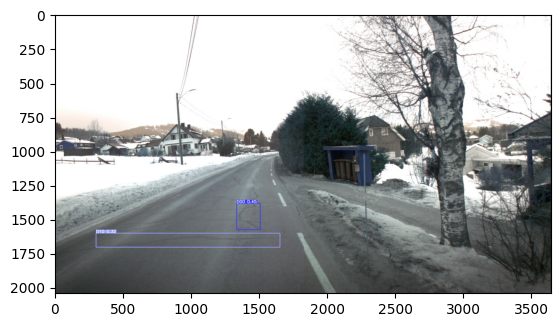

Norway_008247.jpg 1 301 1601 1651 1703 0 1334 1382 1506 1574 


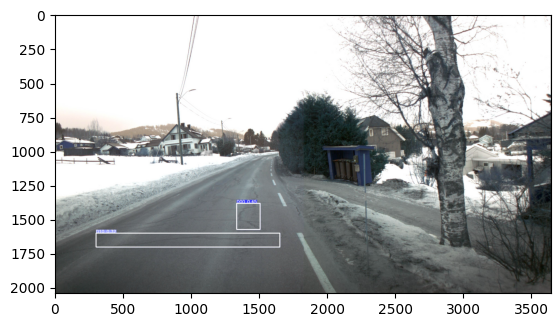

In [24]:
# Get data from text file. NB! All in labels folder has at least 1!
# "Norway_008218.txt" has 3 
# "Norway_008247" has 2 classes present
path = 'yolov5/runs/detect/gpu_single_30/'
name = "Norway_008247"

# Get the labels for the image
with open(path+"labels/"+name+".txt", "r") as rf:
        # Get dimensions to un-normalize
        img = cv2.imread(path+name+".jpg")
        (h, w, _) = img.shape
        plt.imshow(img)
        plt.show()
        
        # Read content 
        lines = rf.readlines()
        s_string = name+".jpg "
        # Look at a single bbox at a time
        for line in lines:
            # Convert to an array.
            one_bbox = np.asarray(line.strip().split(" "), dtype=float)
    
            # Extract relevant data
            cls = one_bbox[0]
            x_center_n, y_center_n = one_bbox[1], one_bbox[2]
            box_w_n, box_h_n = one_bbox[3], one_bbox[4]
            
            # Convert to submission format
            x_center = int(x_center_n*w)
            y_center = int(y_center_n*h)
            
            box_w = int(box_w_n*w)
            box_h = int(box_h_n*h)
            
            x_min = x_center - box_w//2
            x_max = x_center + box_w//2
            y_min = y_center - box_h//2
            y_max = y_center + box_h//2
            
            #print(w, h)
            #print(x_center_n, y_center_n, box_w_n, box_h_n)
            #print(x_center, y_center, box_w, box_h)
            #print(x_min, x_max, y_min, y_max)
            
            s_string+=str(int(cls))+" "+str(x_min)+" "+str(y_min)+" "+str(x_max)+" "+str(y_max)+" "
            
            # Write to submission file
            #with open('submissions/test_submission.txt', 'a') as f:
            #    f.write(s_string+" ")
            
            
            
            
            # Sanity_check: is the coordinates correct?
            # Draw a rectangle with blue line borders of thickness of 2 px
            img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255, 255, 255), thickness=5)

        print(s_string)
        
        
# Displaying the image 
plt.imshow(img)
plt.show()
            
            
            

In [7]:
#path = 'yolov5/runs/detect/gpu_single_30/'
path = 'yolov5/runs/detect/detection_single_gpu_30_high_res/'
submission_name = 'detection_single_gpu_30_high_res'
write = True # Write result to submission file?

test_label_paths = [os.path.join(path+'/labels', x) for x in os.listdir(path+'/labels')]
#label_file_names = [x[-17:-4] for x in test_label_paths]
all_test_img_names = [x[:-4] for x in os.listdir(path) if x[-4:]==".jpg"]
all_test_img_names.sort()


d = {} # Class statistics.
for name in all_test_img_names:
    
    # Get the labels for the image
    s_string = name+".jpg,"
    try:
        with open(path+"labels/"+name+".txt", "r") as rf:
            # Get dimensions to un-normalize
            img = cv2.imread(path+name+".jpg")
            (h, w, _) = img.shape


            # Read content 
            lines = rf.readlines()
            # Look at a single bbox at a time
            for line in lines:
                # Convert to an array.
                one_bbox = np.asarray(line.strip().split(" "), dtype=float)

                # Extract relevant data
                cls = one_bbox[0]+1 #NB! 1-indexed!
                try:
                    d[cls]+=1
                except:
                    d[cls]=1
                x_center_n, y_center_n = one_bbox[1], one_bbox[2]
                box_w_n, box_h_n = one_bbox[3], one_bbox[4]

                # Convert to submission format
                x_center = int(x_center_n*w)
                y_center = int(y_center_n*h)

                box_w = box_w_n*w
                box_h = box_h_n*h

                x_min = int(x_center - box_w/2)
                x_max = int(x_center + box_w/2)
                y_min = int(y_center - box_h/2)
                y_max = int(y_center + box_h/2)

                #print(w, h)
                #print(x_center_n, y_center_n, box_w_n, box_h_n)
                #print(x_center, y_center, box_w, box_h)
                #print(x_min, x_max, y_min, y_max)

                s_string+=str(int(cls))+" "+str(x_min)+" "+str(y_min)+" "+str(x_max)+" "+str(y_max)+" "
                
    except FileNotFoundError: # No labels in image
        pass
        
    # Write to submission file
    if write:
        with open('submissions/'+submission_name+'.txt', 'a') as f:
            f.write(s_string+"\n")






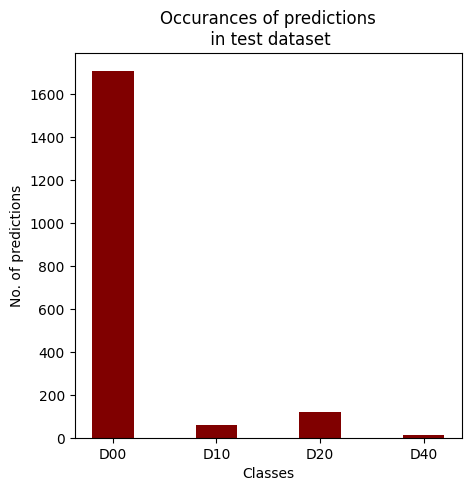

In [9]:
#classes = list(d.keys())
classes = ["D00", "D10", "D20", "D40"]
occurances = list(d.values())

fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(classes, occurances, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of predictions")
plt.title("Occurances of predictions\n in test dataset")

plt.show()

### Why is the model(gpu_single_30) so bad at detecting D20/D40? Alligator/Pothole?

It might be due to the 640pixel resolution used for its training / detection!
- We can set the res also at detection time: might want to give it the full size for this?
- Also: train at higher res!


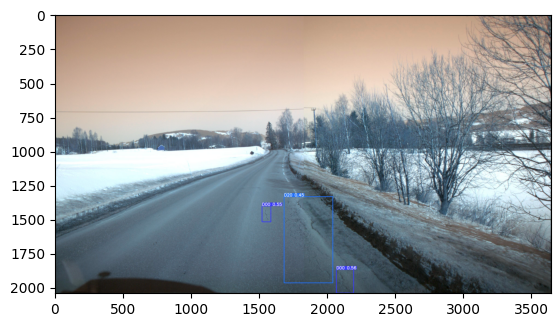

Original Dimensions :  (2041, 3643, 3)
resized Dimensions :  (102, 182, 3)


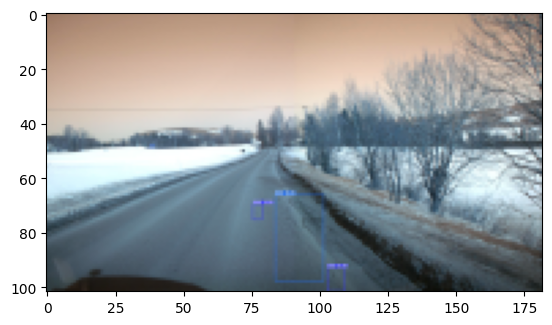

In [16]:
path = 'yolov5/runs/detect/detection_multi_gpu_50_2/'
#path = 'data/test/images/'
name = "Norway_008218"

img = cv2.imread(path+name+".jpg") 
plt.imshow(img)
plt.show()
print('Original Dimensions : ',img.shape)
scale_percent = 5 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('resized Dimensions : ',resized.shape)
plt.imshow(resized)
plt.show()

### What if we have more than 5 detections in one image? 

- Only the 5 first is concidered by the submission system=> Should therefor order by confidence!
- To get confidence, set the flag "--save-conf" for detection.py.

In [12]:
path = 'yolov5/runs/detect/detection_multi_gpu_50_2/'
submission_name = 'multi_gpu_50_sorted'
write = True # Write result to submission file?

test_label_paths = [os.path.join(path+'/labels', x) for x in os.listdir(path+'/labels')]
#label_file_names = [x[-17:-4] for x in test_label_paths]
all_test_img_names = [x[:-4] for x in os.listdir(path) if x[-4:]==".jpg"]
all_test_img_names.sort()

stats_dict = {} # Class statistics.
for name in all_test_img_names:
    
    # Get the labels for the image
    #s_string = name+".jpg,"
    labels_found = True
    try:
        with open(path+"labels/"+name+".txt", "r") as rf:
            # Get dimensions to un-normalize
            img = cv2.imread(path+name+".jpg")
            (h, w, _) = img.shape


            # Read content 
            lines = rf.readlines()
            labels_one_image_dict = {} # save {conf: [cls, xmin, ymin, xmax, ymax]}
            # Look at a single bbox at a time
            for line in lines:
                # Convert to an array.
                one_bbox = np.asarray(line.strip().split(" "), dtype=float)

                # Extract relevant data
                cls = one_bbox[0]+1 #NB! 1-indexed!
                try:
                    stats_dict[cls]+=1
                except:
                    stats_dict[cls]=1
                x_center_n, y_center_n = one_bbox[1], one_bbox[2]
                box_w_n, box_h_n = one_bbox[3], one_bbox[4]
                
                # Confidence
                conf = one_bbox[5]

                # Convert to submission format
                x_center = int(x_center_n*w)
                y_center = int(y_center_n*h)

                box_w = box_w_n*w
                box_h = box_h_n*h

                x_min = int(x_center - box_w/2)
                x_max = int(x_center + box_w/2)
                y_min = int(y_center - box_h/2)
                y_max = int(y_center + box_h/2)
                
                #
                labels_one_image_dict[float(conf)] = [str(int(cls)), str(x_min), str(y_min), str(x_max), str(y_max)]
                #s_string+=str(int(cls))+" "+str(x_min)+" "+str(y_min)+" "+str(x_max)+" "+str(y_max)+" "
                
    except FileNotFoundError: # No labels in image
        labels_found=False
        
    # Write to submission file
    if write:
        s_string = name+".jpg,"
        with open('submissions/'+submission_name+'.txt', 'a') as f:
            
            if labels_found:

                for key in sorted(labels_one_image_dict.keys(), reverse=True): # Iterate by confidence
                    val = labels_one_image_dict[key]
                    s_string+=val[0]+" "+val[1]+" "+val[2]+" "+val[3]+" "+val[4]+" "
                
            f.write(s_string+"\n")






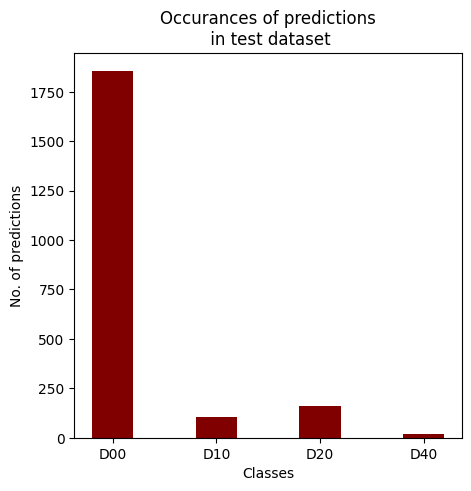

In [13]:
#classes = list(d.keys())
classes = ["D00", "D10", "D20", "D40"]
occurances = list(stats_dict.values())

fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(classes, occurances, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of predictions")
plt.title("Occurances of predictions\n in test dataset")

plt.show()

In [10]:
d = {0.25: ["din", "gale", "sei"],0.21: ["lever", "postei"], 0.54: ["hei", "på", "deg"]}
for key in sorted(d.keys(), reverse=True):
    print("key:",key)
    print("value", d[key])


key: 0.54
value ['hei', 'på', 'deg']
key: 0.25
value ['din', 'gale', 'sei']
key: 0.21
value ['lever', 'postei']
